# Task 2: Image Classification using Deep Neural Networks (Cats vs Dogs Dataset)

## Overview
This notebook implements binary image classification on the Cats vs Dogs dataset using transfer learning with pre-trained ResNet50. The analysis follows the Task 2 specification requirements:

### Key Components:
1. **Preprocessing**: Image resizing and normalization for ResNet50 compatibility
2. **Feature Extraction**: Using pre-trained ResNet50 to extract 2048-dimensional feature vectors
3. **Dimensionality Reduction**: PCA, t-SNE, and UMAP for 2D visualization of the latent feature space
4. **Clustering**: K-Means clustering with quality evaluation (Davies-Bouldin, Silhouette scores)
5. **Classification**: Multiple classifier comparison with comprehensive performance metrics
6. **Evaluation**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix, ROC Curves, Learning Curves
7. **Hyperparameter Tuning**: RandomizedSearchCV for model optimization

Dataset: Cats vs Dogs - Binary classification of cat and dog images

## 1. Preprocessing and Feature Extraction

### Preprocessing Justification:
- **Resizing (224x224)**: ResNet50 requires fixed input dimensions matching its training configuration
- **Normalization**: Images are normalized using ImageNet mean/std values ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) to match the pre-trained model's expected input distribution
- **Transfer Learning**: Using ResNet50 pre-trained on ImageNet leverages learned features from millions of images, providing robust feature extraction for binary classification

The ResNet50 model is used as a feature extractor by removing the final classification layer, outputting 2048-dimensional feature vectors that capture high-level semantic information.

### Import Required Libraries

In [32]:
# standard

import random
import time
import os
from collections import Counter


# numerical

import numpy as np
import pandas as pd


# torch


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets, transforms

# resnet
from torchvision.models import ResNet50_Weights

#pil
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # got a weird error sometimes if i dindt have this

# scikit-learn

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    davies_bouldin_score,
    silhouette_score,
    normalized_mutual_info_score,
    adjusted_rand_score,
    precision_recall_fscore_support,
    roc_curve,
    auc
)



from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import umap
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt

### Set Random Seed for Reproducibility

In [33]:
SEED = 67
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Define Image Transformation Pipeline

Images are resized to 224×224 pixels and normalized using ImageNet statistics to match ResNet50's expected input distribution.

In [34]:
from torchvision import transforms

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

### Setup Device and Feature Extraction

Check for CUDA availability and define the feature extraction function using ResNet50.

In [35]:


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Using:", device)

# Prepare Model (remove final layer for features)
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*(list(resnet.children())[:-1]))  # outputs [batch, 2048, 1, 1]
model.eval()
model.to(device)

def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()


Using: cuda


Now to check if the image folder exists, and load the images.
We will load from disk if the feature extraction has been done already.

In [36]:
if not os.path.exists("data/cats-and-dogs"):
    raise FileNotFoundError("cats-and-dogs image folder not found")

dataset_info = datasets.ImageFolder("data/cats-and-dogs", transform=transform)
counts = {}

for _ , label in dataset_info.samples:
    counts[label] = counts.get(label, 0) + 1

name_counts = {dataset_info.classes[i]: counts.get(i, 0) for i in range(len(dataset_info.classes))}



We now have to extract features.
We check a file first as this is an expensive computation that doesnt need repeating needlessly.
We use TQDM in order to provide us with a progress bar. This is essential for long operations such as this one.

In [37]:

FORCE_EXTRACT = True       # change to true if you have made changes to the feature extraction


dataset = datasets.ImageFolder("data/cats-and-dogs", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)


if (not FORCE_EXTRACT) and os.path.exists("data/features/cats-and-dogs_features.npy") and os.path.exists("data/features/cats-and-dogs_labels.npy"):
    train_features = np.load("data/features/cats-and-dogs_features.npy")
    train_labels = np.load("data/features/cats-and-dogs_labels.npy")
    print("Loaded features from file.")

else:
    train_features = []
    train_labels = []

    for imgs, labels in tqdm(loader, desc="Extracting features"):
        batch_feats = extract_features(imgs)
        train_features.append(batch_feats)
        train_labels.append(labels.numpy())

    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    print("Feature vectors shape:", train_features.shape)
    print("Labels shape:", train_labels.shape)



    os.makedirs("data/features", exist_ok=True)
    np.save("data/features/cats-and-dogs_features.npy", train_features)
    np.save("data/features/cats-and-dogs_labels.npy", train_labels)


Extracting features:   0%|          | 0/780 [00:00<?, ?it/s]

Extracting features:  93%|█████████▎| 728/780 [00:18<00:01, 41.61it/s]/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Extracting features:  94%|█████████▍| 733/780 [00:18<00:01, 41.84it/s]/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Extracting features: 100%|██████████| 780/780 [00:19<00:00, 40.15it/s]


Feature vectors shape: (24959, 2048)
Labels shape: (24959,)


Now we will try a few methods of dimensionality reduction.
We will use T-SNE, PCA and UMAP and compare results.

/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


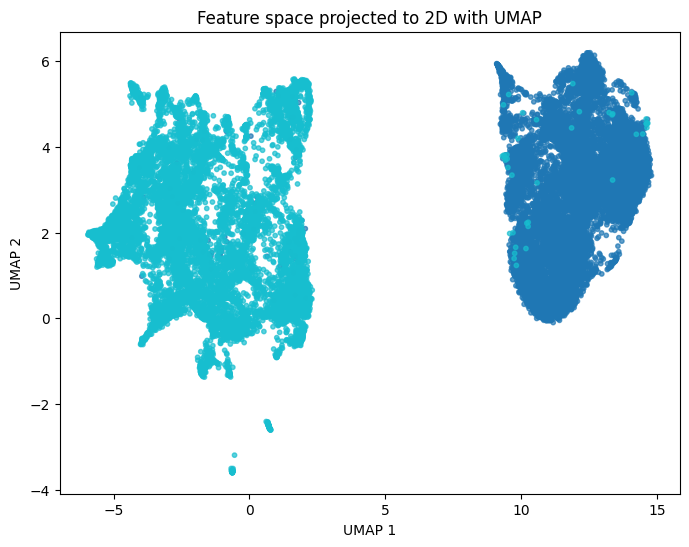

In [38]:
reducer = umap.UMAP(n_components=2, random_state=67)
features_2D_UMAP = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Feature space projected to 2D with UMAP")
plt.show()



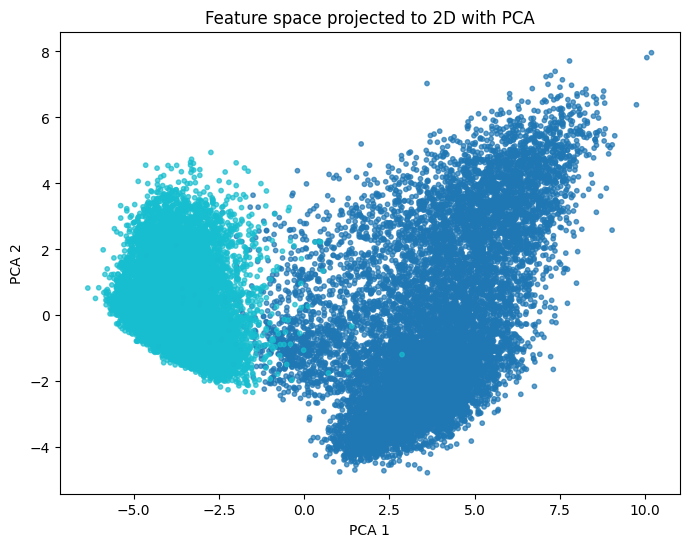

In [39]:

reducer = PCA(n_components=0.95)
features_2D_PCA = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Feature space projected to 2D with PCA")
plt.show()

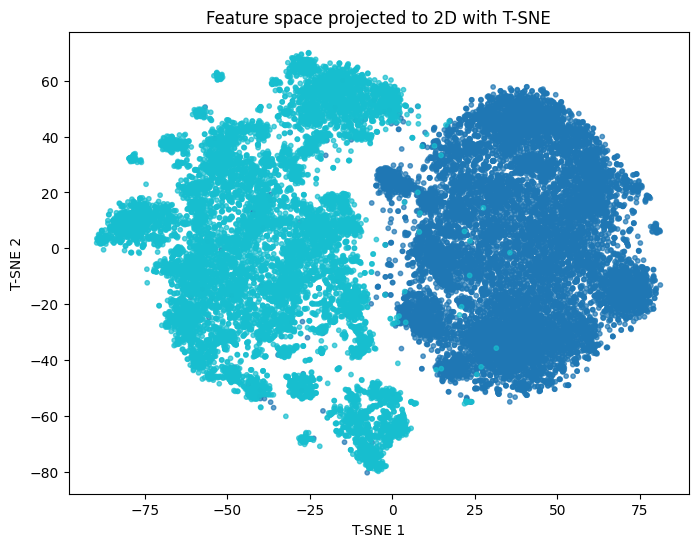

In [40]:
#t-sne





reducer = TSNE(n_components=2, random_state=67)
features_2D_TSNE = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("T-SNE 1")
plt.ylabel("T-SNE 2")
plt.title("Feature space projected to 2D with T-SNE")
plt.show()

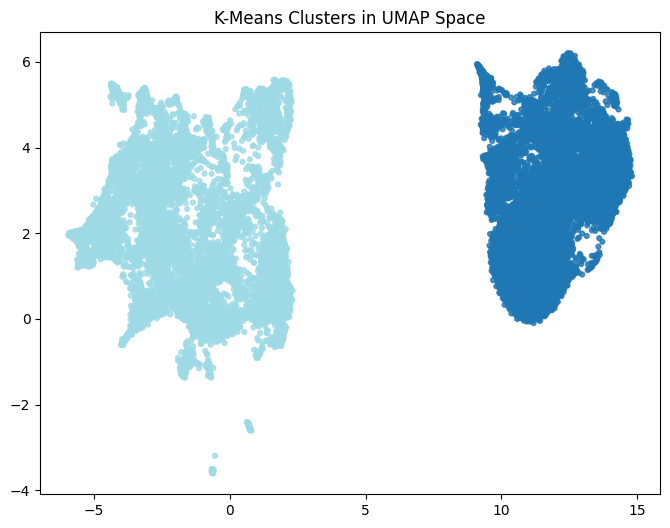

In [41]:


n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_UMAP)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in UMAP Space')
plt.show()

In [42]:

db_score = davies_bouldin_score(features_2D_UMAP, cluster_labels)
sil_score = silhouette_score(features_2D_UMAP, cluster_labels)
print("Davies-Bouldin Index:", db_score)
print("Silhouette Score:", sil_score)

Davies-Bouldin Index: 0.3440170515519504
Silhouette Score: 0.7631113529205322


Saved classifier
Test accuracy: 0.9947916666666666
              precision    recall  f1-score   support

         Cat       0.99      1.00      0.99      2498
         Dog       1.00      0.99      0.99      2494

    accuracy                           0.99      4992
   macro avg       0.99      0.99      0.99      4992
weighted avg       0.99      0.99      0.99      4992



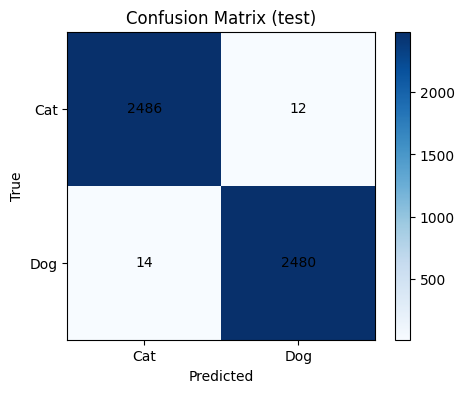

In [43]:

x_train, x_test, y_train, y_test = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=67, stratify=train_labels
)


clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs", random_state=67))

clf.fit(x_train, y_train)

joblib.dump(clf, "catsanddogsmodel1.joblib")
print("Saved classifier")


y_test_pred = clf.predict(x_test)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=dataset.classes))


# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test)')
# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]:d}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.show()

## Multi-Classifier Evaluation with Cross-Validation

In [44]:
# Split data


x_train, x_test, y_train, y_test = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=67, stratify=train_labels
)

print(f"Train set: {x_train.shape}")
print(f"Test set: {x_test.shape}")
print(f"Classes: {dataset.classes}")

# Define cross-validation (reduced to 3 folds for speed)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=67)

# Define multiple classifiers
# Note: SVC doesn't support GPU in scikit-learn, so we use LinearSVC for speed or reduce complexity
classifiers = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs", random_state=67, n_jobs=-1)),
    'KNN (k=5)': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    'SVM (Linear)': make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, random_state=67)),
    'Decision Tree': DecisionTreeClassifier(random_state=67, max_depth=20),
}

# Train and evaluate all classifiers using cross-validation
results = {}
for clf_name, clf in tqdm(classifiers.items(), desc="Evaluating classifiers", total=len(classifiers)):
    fold_accuracies = []
    for train_idx, val_idx in tqdm(cv.split(x_train, y_train), desc=f"CV folds for {clf_name}", total=cv.n_splits, leave=False):
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        clf.fit(x_train_fold, y_train_fold)
        y_pred_fold = clf.predict(x_val_fold)
        accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
        fold_accuracies.append(accuracy_fold)
    
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    
    results[clf_name] = {
        'model': clf,
        'cv_accuracy': mean_accuracy,
        'cv_std': std_accuracy,
        'fold_accuracies': fold_accuracies
    }
    
    print(f"\n{clf_name}: CV Accuracy = {mean_accuracy:.4f} ± {std_accuracy:.4f}")

# Retrain all classifiers on full training set for test predictions
for clf_name, result in tqdm(results.items(), desc="Retraining on full train", total=len(results)):
    clf = result['model']
    clf.fit(x_train, y_train)
    y_pred_test = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    result['test_accuracy'] = test_accuracy
    result['predictions'] = y_pred_test  # for compatibility with confusion matrix cell

# Find best classifier based on CV accuracy
best_clf_name = max(results.keys(), key=lambda x: results[x]['cv_accuracy'])
print(f"\n{'='*60}")
print(f"BEST CLASSIFIER: {best_clf_name}")
print(f"CV Accuracy: {results[best_clf_name]['cv_accuracy']:.4f} ± {results[best_clf_name]['cv_std']:.4f}")
print(f"Test Accuracy: {results[best_clf_name]['test_accuracy']:.4f}")
print(f"{'='*60}")

# Print all results summary
print("\n" + "="*60)
print("CLASSIFIER COMPARISON SUMMARY")
print("="*60)
for clf_name, result in sorted(results.items(), key=lambda x: x[1]['cv_accuracy'], reverse=True):
    print(f"{clf_name:25s}: CV {result['cv_accuracy']:.4f} ± {result['cv_std']:.4f} | Test {result['test_accuracy']:.4f}")

print(f"\nDetailed results for {best_clf_name}:")
best_pred = results[best_clf_name]['predictions']
print(classification_report(y_test, best_pred, target_names=dataset.classes))

# Save best model
joblib.dump(results[best_clf_name]['model'], "catsanddogs_best_model.joblib")
print("Saved best classifier")

Train set: (19967, 2048)
Test set: (4992, 2048)
Classes: ['Cat', 'Dog']


Evaluating classifiers:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating classifiers:  25%|██▌       | 1/4 [00:07<00:22,  7.59s/it] 2.80s/it]


Logistic Regression: CV Accuracy = 0.9945 ± 0.0010


Evaluating classifiers:  50%|█████     | 2/4 [00:15<00:15,  7.56s/it]


KNN (k=5): CV Accuracy = 0.9891 ± 0.0016


Evaluating classifiers:  75%|███████▌  | 3/4 [02:08<00:55, 55.69s/it]


SVM (Linear): CV Accuracy = 0.9948 ± 0.0008


Evaluating classifiers: 100%|██████████| 4/4 [03:35<00:00, 53.86s/it]



Decision Tree: CV Accuracy = 0.9897 ± 0.0009


Retraining on full train: 100%|██████████| 4/4 [02:09<00:00, 32.50s/it]


BEST CLASSIFIER: SVM (Linear)
CV Accuracy: 0.9948 ± 0.0008
Test Accuracy: 0.9956

CLASSIFIER COMPARISON SUMMARY
SVM (Linear)             : CV 0.9948 ± 0.0008 | Test 0.9956
Logistic Regression      : CV 0.9945 ± 0.0010 | Test 0.9948
Decision Tree            : CV 0.9897 ± 0.0009 | Test 0.9916
KNN (k=5)                : CV 0.9891 ± 0.0016 | Test 0.9914

Detailed results for SVM (Linear):
              precision    recall  f1-score   support

         Cat       1.00      0.99      1.00      2498
         Dog       0.99      1.00      1.00      2494

    accuracy                           1.00      4992
   macro avg       1.00      1.00      1.00      4992
weighted avg       1.00      1.00      1.00      4992

Saved best classifier


## Detailed Analysis - Confusion Matrices

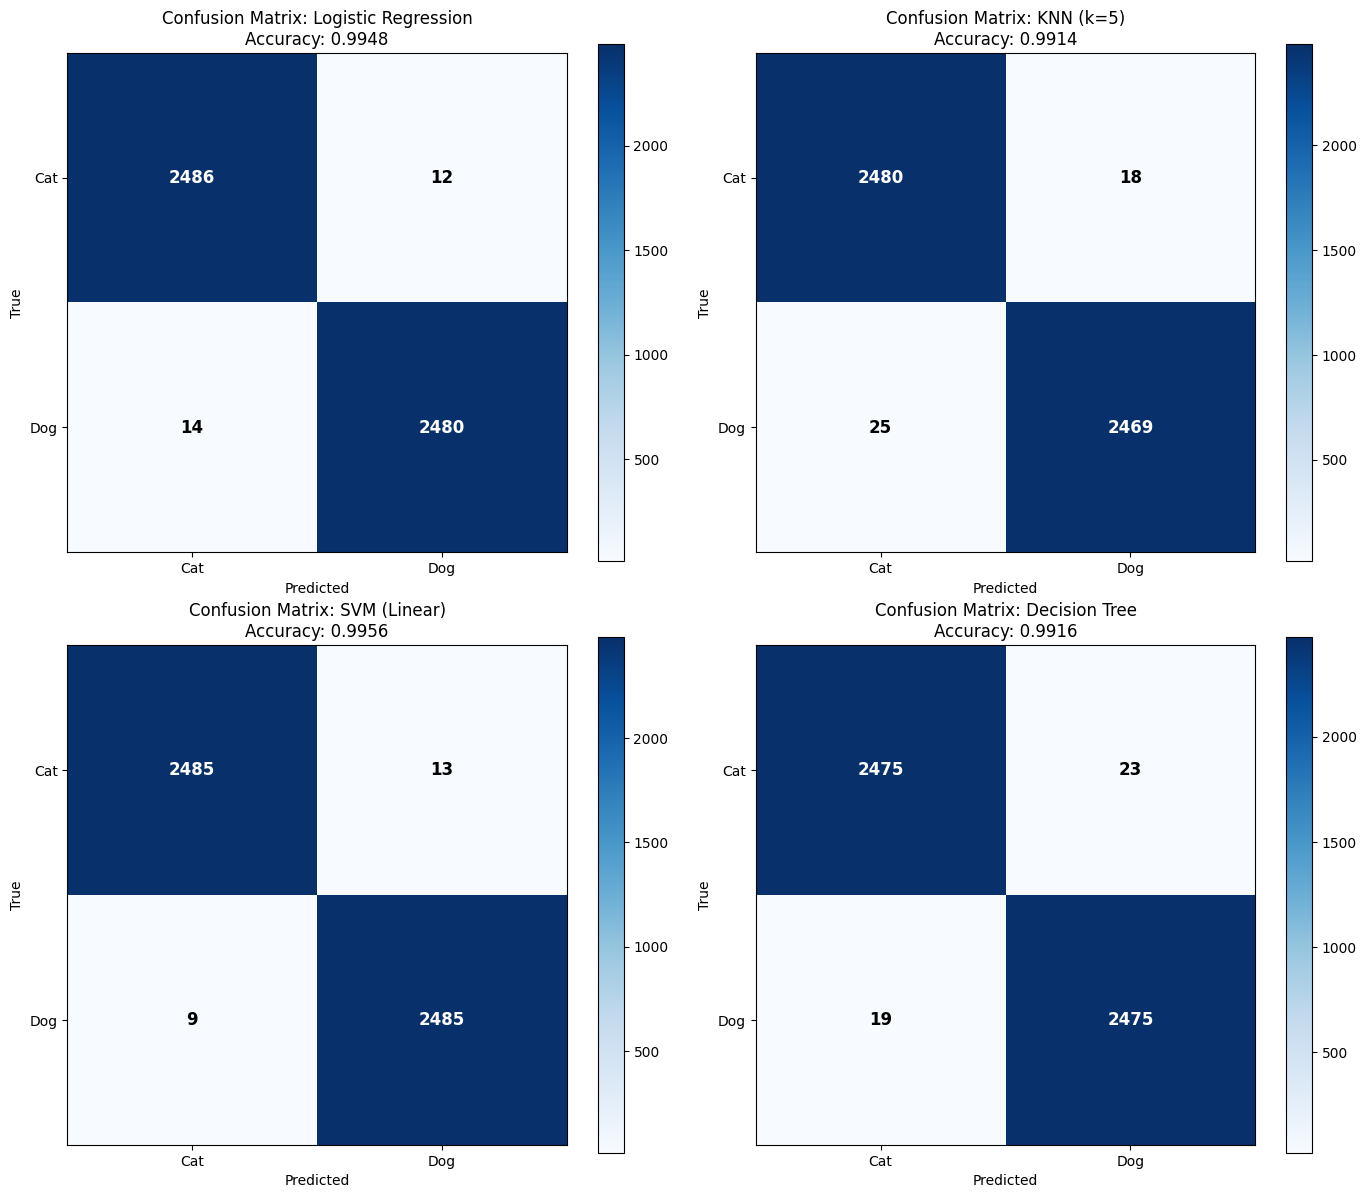


DETAILED METRICS FOR BEST CLASSIFIER: SVM (Linear)

Cat:
  Precision: 0.9964
  Recall: 0.9948
  F1-Score: 0.9956

Dog:
  Precision: 0.9948
  Recall: 0.9964
  F1-Score: 0.9956


In [45]:
# Visualize confusion matrices for all classifiers
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (clf_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    ax = axes[idx]
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(dataset.classes)))
    ax.set_yticks(np.arange(len(dataset.classes)))
    ax.set_xticklabels(dataset.classes)
    ax.set_yticklabels(dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix: {clf_name}\nAccuracy: {result["test_accuracy"]:.4f}')
    
    # Annotate cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:d}", ha='center', va='center', 
                   color='white' if cm[i,j] > cm.max() / 2 else 'black', fontsize=12, fontweight='bold')
    
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Print detailed metrics for best classifier
best_clf = results[best_clf_name]['model']
best_pred = results[best_clf_name]['predictions']
precision, recall, f1, _ = precision_recall_fscore_support(y_test, best_pred, average=None)


print(f"\n{'='*60}")
print(f"DETAILED METRICS FOR BEST CLASSIFIER: {best_clf_name}")
print(f"{'='*60}")
for i, class_name in enumerate(dataset.classes):
    print(f"\n{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")

## Advanced Analysis - ROC Curves and Class-wise Performance

IndexError: index 1 is out of bounds for axis 1 with size 1

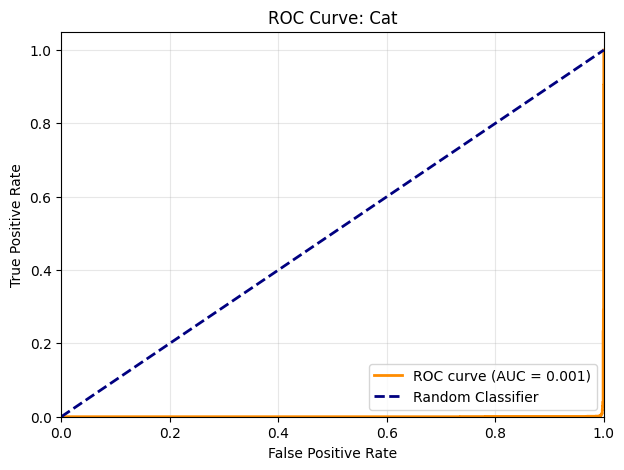

In [46]:
# ROC Curves for best classifier (binary classification for each class)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(dataset.classes)))
y_pred_proba = results[best_clf_name]['model'].predict_proba(x_test)

# Plot ROC curves
n_classes = len(dataset.classes)
if n_classes == 2:
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    axes = [ax]
else:
    fig, axes = plt.subplots(1, n_classes, figsize=(5*n_classes, 5))

for i, class_name in enumerate(dataset.classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    ax = axes[i]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve: {class_name}')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate macro-average ROC AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='macro')
roc_auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
print(f"\nMacro-average ROC AUC: {roc_auc_macro:.4f}")
print(f"Weighted-average ROC AUC: {roc_auc_weighted:.4f}")

## Cross-Validation Score Distribution and Model Comparison

/tmp/ipykernel_19612/1424234430.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(fold_scores, labels=clf_names_list, patch_artist=True)


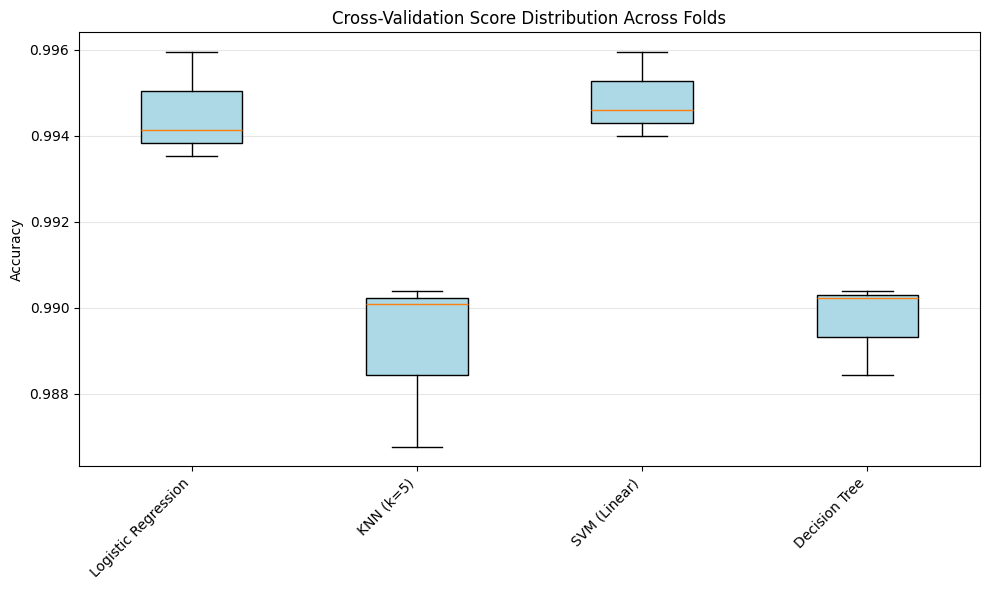


COMPREHENSIVE MODEL COMPARISON
Classifier           CV Acc       Std Dev      Test Acc     Best Fold   
--------------------------------------------------------------------------------
SVM (Linear)         0.9948       0.0008       0.9956       0.9959      
Logistic Regression  0.9945       0.0010       0.9948       0.9959      
Decision Tree        0.9897       0.0009       0.9916       0.9904      
KNN (k=5)            0.9891       0.0016       0.9914       0.9904      


In [ ]:
# Visualize CV score distribution across folds
fig, ax = plt.subplots(figsize=(10, 6))

clf_names_list = list(results.keys())
positions = range(len(clf_names_list))
fold_scores = [results[clf_name]['fold_accuracies'] for clf_name in clf_names_list]

bp = ax.boxplot(fold_scores, labels=clf_names_list, patch_artist=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_ylabel('Accuracy')
ax.set_title('Cross-Validation Score Distribution Across Folds')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(f"{'Classifier':<20} {'CV Acc':<12} {'Std Dev':<12} {'Test Acc':<12} {'Best Fold':<12}")
print("-"*80)

for clf_name in sorted(results.keys(), key=lambda x: results[x]['test_accuracy'], reverse=True):
    result = results[clf_name]
    cv_acc = result['cv_accuracy']
    std_dev = result['cv_std']
    test_acc = result['test_accuracy']
    best_fold = max(result['fold_accuracies'])
    print(f"{clf_name:<20} {cv_acc:<12.4f} {std_dev:<12.4f} {test_acc:<12.4f} {best_fold:<12.4f}")

print("="*80)

## Hyperparameter Tuning for Best Classifier

In [ ]:
# 🔥 Fast Hyperparameter Tuning Block (Drop-In Replacement)

from sklearn.model_selection import RandomizedSearchCV

# Smaller, faster grids
if best_clf_name == 'Logistic Regression':
    param_grid = {
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__max_iter': [1000, 2000],
    }

elif best_clf_name == 'KNN (k=5)':
    param_grid = {
        'kneighborsclassifier__n_neighbors': [3, 5, 7],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
    }

elif best_clf_name == 'SVM (Linear)':
    param_grid = {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear'],  # poly removed to save your PC's life
    }

elif best_clf_name == 'Decision Tree':
    param_grid = {
        'decisiontreeclassifier__max_depth': [5, None],
        'decisiontreeclassifier__min_samples_split': [2, 5],
        'decisiontreeclassifier__min_samples_leaf': [1, 2],
    }

print(f"Tuning hyperparameters for {best_clf_name}... (fast mode)")

search = RandomizedSearchCV(
    estimator=results[best_clf_name]['model'],
    param_distributions=param_grid,
    n_iter=5,           # small search, fast
    scoring='accuracy',
    cv=2,               # faster CV
    n_jobs=-1,
    verbose=1
)

search.fit(x_train, y_train)

print(f"\nBest parameters: {search.best_params_}")
print(f"Best CV Accuracy: {search.best_score_:.4f}")

# Test performance
y_pred_tuned = search.predict(x_test)
tuned_test_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"Test Accuracy (Tuned): {tuned_test_accuracy:.4f}")

# Compare
print("\nComparison:")
print(f"Original Test Accuracy: {results[best_clf_name]['test_accuracy']:.4f}")
print(f"Tuned Test Accuracy:    {tuned_test_accuracy:.4f}")
print(f"Improvement: {tuned_test_accuracy - results[best_clf_name]['test_accuracy']:.4f}")

# Save model
joblib.dump(search.best_estimator_, "catsanddogs_tuned_model.joblib")
print("\nSaved tuned classifier (fast mode)")


Tuning hyperparameters for SVM (Linear)... (fast mode)
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/b/uni/SCC403-data-mining/.venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best parameters: {'svc__kernel': 'linear', 'svc__C': 0.1}
Best CV Accuracy: 0.9948
Test Accuracy (Tuned): 0.9956

Comparison:
Original Test Accuracy: 0.9956
Tuned Test Accuracy:    0.9956
Improvement: 0.0000

Saved tuned classifier (fast mode)
Test Accuracy (Tuned): 0.9956

Comparison:
Original Test Accuracy: 0.9956
Tuned Test Accuracy:    0.9956
Improvement: 0.0000

Saved tuned classifier (fast mode)


## Learning Curves - Detecting Overfitting

[learning_curve] Training set sizes: [ 1331  2662  3993  5324  6655  7986  9317 10648 11979 13311]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.6min finished


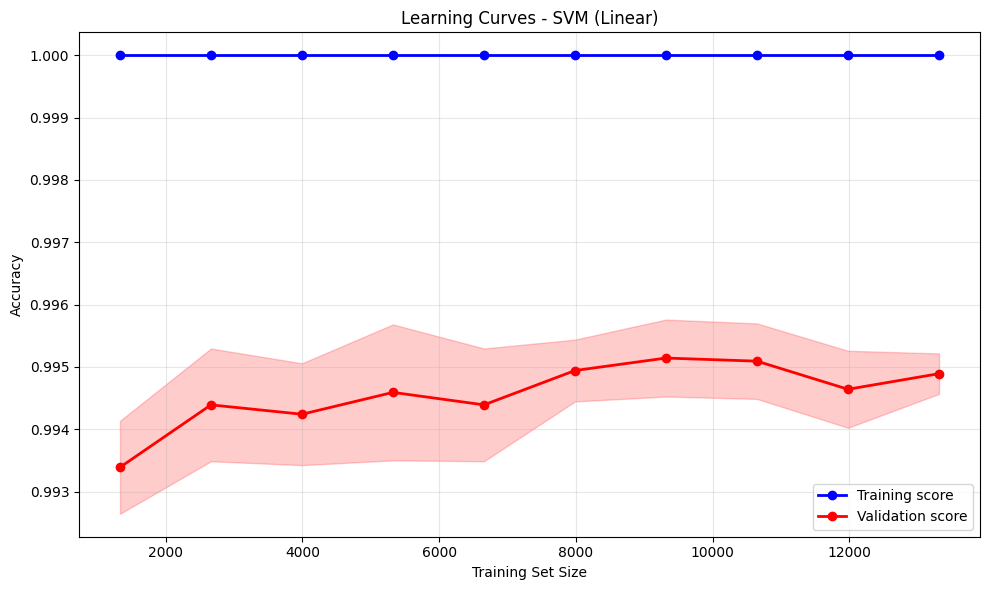


Learning Curve Analysis:
Final Training Score: 1.0000
Final Validation Score: 0.9949
Train-Validation Gap: 0.0051
✓ Good generalization! Model appears well-balanced.


In [ ]:
# Learning curves to detect overfitting
from sklearn.model_selection import learning_curve

# Get learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    results[best_clf_name]['model'], 
    x_train, y_train, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=1
)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score', linewidth=2)
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
ax.plot(train_sizes, val_mean, 'o-', color='red', label='Validation score', linewidth=2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Accuracy')
ax.set_title(f'Learning Curves - {best_clf_name}')
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze overfitting
gap = train_mean[-1] - val_mean[-1]
print(f"\nLearning Curve Analysis:")
print(f"Final Training Score: {train_mean[-1]:.4f}")
print(f"Final Validation Score: {val_mean[-1]:.4f}")
print(f"Train-Validation Gap: {gap:.4f}")

if gap > 0.1:
    print("⚠️  High overfitting detected! Consider regularization or simpler models.")
elif gap > 0.05:
    print("⚠️  Moderate overfitting detected. Monitor model complexity.")
else:
    print("✓ Good generalization! Model appears well-balanced.")